In [1]:
import numpy as np
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# Data Preprocessing:

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score, accuracy_score

# Models:

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# A model that I learned by myself: CatBoost + Plotly

from catboost import CatBoostClassifier
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

# offline (for plotly)

import plotly.offline as pyo

# Clustering:

from sklearn.cluster import KMeans

# PCA:

from sklearn.decomposition import PCA

# ICA:

from sklearn.decomposition import FastICA

# Scaling:

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# Cross Validation:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [2]:
# loading the data
# the data is already split to train and test
df_train = pd.read_csv("fashion-mnist_train.csv")
df_test = pd.read_csv("fashion-mnist_test.csv")

In [3]:
# the first 5 rows of the data
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# As we can see, we have a lot to train on
df_train.shape

(60000, 785)

In [5]:
# and a lot to train on
df_test.shape

(10000, 785)

In [6]:
df_train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [7]:
# the data is already clean in the train and the test

In [8]:
df_train.isnull().sum().sum()

0

In [9]:
df_test.isnull().sum().sum()

0

In [10]:
# a function that "translate" a label number to the clothing type it present
def label_numbers_to_clothes(lables):
    casting = {0 :'T-Shirt/Top',
    1 :'Trouser',
    2 :'Pullover',
    3 :'Dress',
    4 :'Coat',
    5 :'Sandal',
    6 :'Shirt',
    7 :'Sneaker',
    8 :'Bag',
    9 :'Ankle Boot'}
    label_copy = lables.copy().map(casting)
    return label_copy

In [11]:
# number of different lables (clothes)
df_train['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [12]:
# plt.figure(figsize=(20, 15))
# sb.heatmap(df_train.corr(), annot=True, cmap="Blues");

In [13]:
# cor = df_train.corr()

In [14]:
# the target will be the label column (which we want to predict)
# the features will be the whole data except the label column (through that data we will predict the label)
targets_train = df_train['label']
features_train = df_train.drop(['label'], axis = 1)

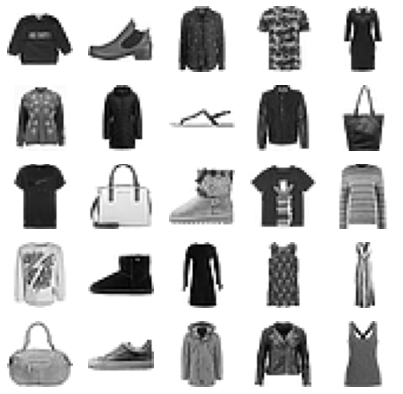

In [15]:
# let's present some of data by image
fig, ax = plt.subplots(5,5, figsize=(7,7))
ax= ax.ravel()
for i in range(25):
    ax[i].imshow(features_train.values.reshape(features_train.shape[0],28,28)[i], cmap = 'binary') 
    ax[i].axis('off')
plt.show()

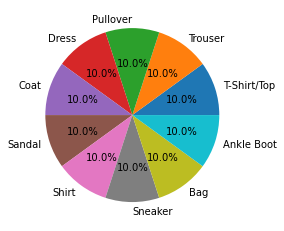

In [16]:
items_dict = dict(targets_train.value_counts())
lables = items_dict.keys()
lables = pd.Series(lables)
values = items_dict.values()
plt.pie(values, labels=label_numbers_to_clothes(lables), autopct='%1.1f%%')
plt.show()

In [17]:
# As we can see, each label number (clothing type) has the same data percent as everyone else,
# means that the data is perfectly balanced

In [18]:
# Spliting the data into train and test parts
# The train_test_split() method splits the data according to a random state,
# if we'll choose some random state, than over multiple reruns,
# the resulting dataframes from the method remain the same (we chose random state 7).

In [19]:
X_train, X_val, y_train, y_val = train_test_split(features_train, targets_train, test_size=0.2, random_state=7)

In [20]:
# Scaling
# Before we split the data into train and test sets, we must scale the values, we chose doing that by standarlization.
# basic_scale = StandardScaler()
# X_train = basic_scale.fit_transform(X_train)
# X_val = basic_scale.transform(X_val)

In [21]:
# Dimensional reduction
# we have a lot of data amout (784 pixels), if we can decrease the number of pixels our model will learn from it will help us
# by doing it faster (and by that, it won't take forever..).

# First of all, let's see how much the data is affected by each column
pca = PCA()
pca.fit(X_train)

PCA()

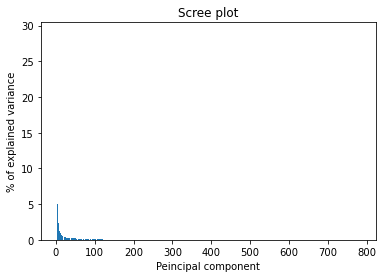

In [22]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.ylabel('% of explained variance')
plt.xlabel('Peincipal component')
plt.title('Scree plot')
plt.show()
# from here we can see that not all of the pixels are relevant for predicting the clothing type
# Moreover, most of the variation is along the first PC (pixel 1)

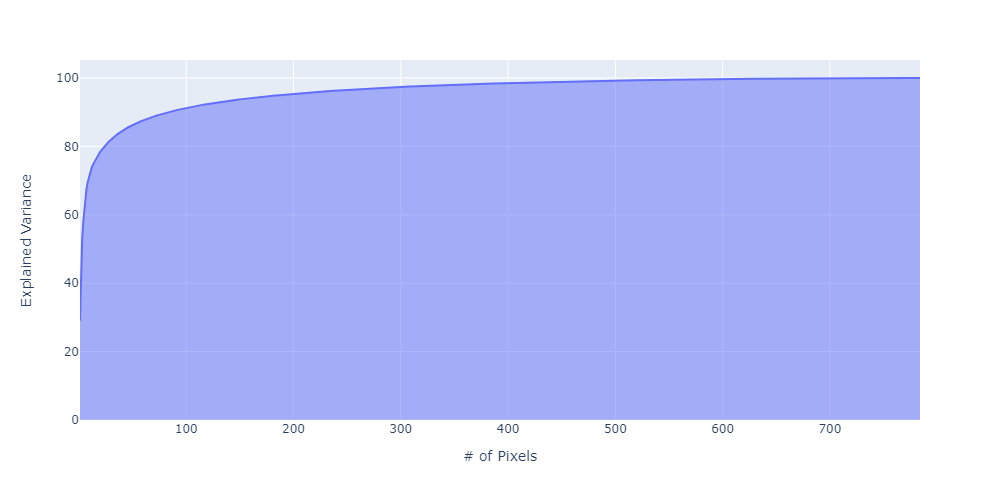

In [23]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.area(
    x=range(1, exp_var_cumul.shape[0]+1),
    y=exp_var_cumul * 100,
    labels={"x": "# of Pixels", "y": "Explained Variance"},
    width = 1000 ,
    height = 500
)

fig.show("png")
# from here we can actually see how much data percent we can get using number of pixels

In [24]:
# if we would like to get a 95% of our data accuracy, we need only 187 columns.
# that's great, but not enough..
# let's try to reduce the number of columns more
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
pca.n_components_

187

In [25]:
# to get a 90% of our data accuracy, we need only 84 columns.
# let's continue doing so
pca = PCA(n_components=0.9)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
pca.n_components_

84

In [26]:
# to get a 85% of our data accuracy, we need only 43 columns.
pca = PCA(n_components=0.85)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
pca.n_components_

43

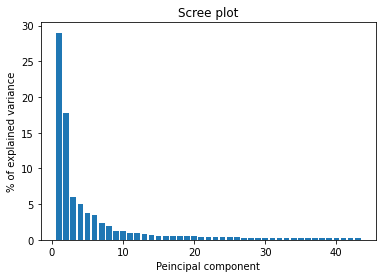

In [27]:
# Let's check the variance percentage in each of the 24 pixels
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.ylabel('% of explained variance')
plt.xlabel('Peincipal component')
plt.title('Scree plot')
plt.show()

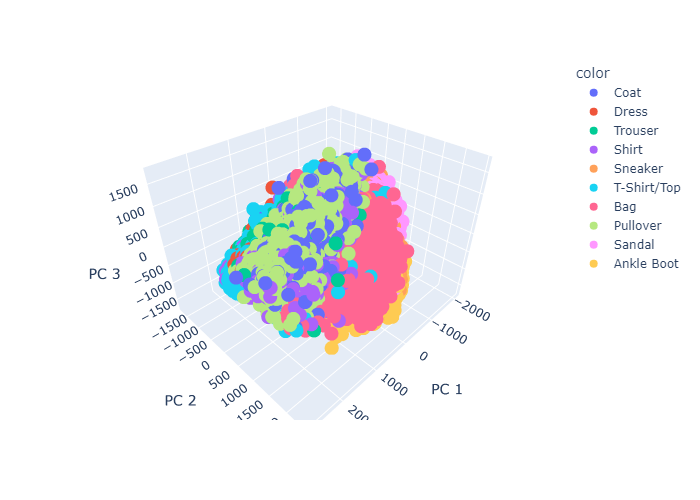

In [28]:
# As we can see from the above, each pixel has lower variance percentage than the pixel before,
# and the first 2 pixels (pixel 1 and pixel 2) has the most variance percentage (in a high gap).
# First, let's scatter a 3D graph using the pixel1, pixel2 and pixel3 (the pixels top 3 variance percentage)
total_var = pca.explained_variance_ratio_.sum() * 100
y_train[0]
fig = px.scatter_3d(X_train_reduced,
    x=0, y=1, z=2, color = label_numbers_to_clothes(y_train),
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
fig.show("png")

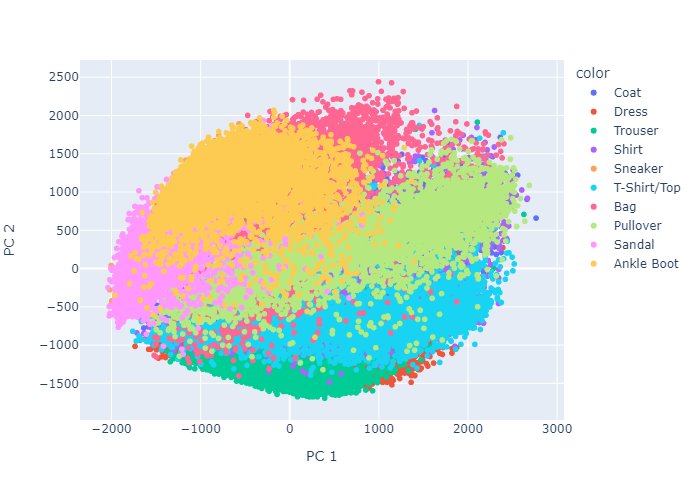

In [29]:
# Well, this 3D graph is cool, it shows us how the data is spread in those 3 axis's.
# Let's present a 2D graph with the 2 PC's that has the highest variance (PC1 and PC2 - 37%)
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=0, y=1, color = label_numbers_to_clothes(y_train),
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

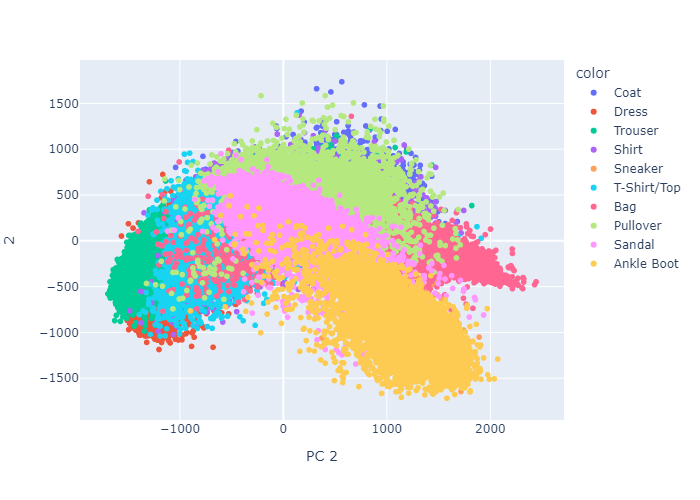

In [30]:
# now we can actually see that if we will choose differnt axis's that we will see the data spread not as good as before,
# because in the above we had a 2D graph with the top 2 variance percentage.
# In other words, this graph will not neccessary be less good looking, but for sure it will be less accurate.
# 2D graph (PC2 and PC3)
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=1, y=2, color = label_numbers_to_clothes(y_train),
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

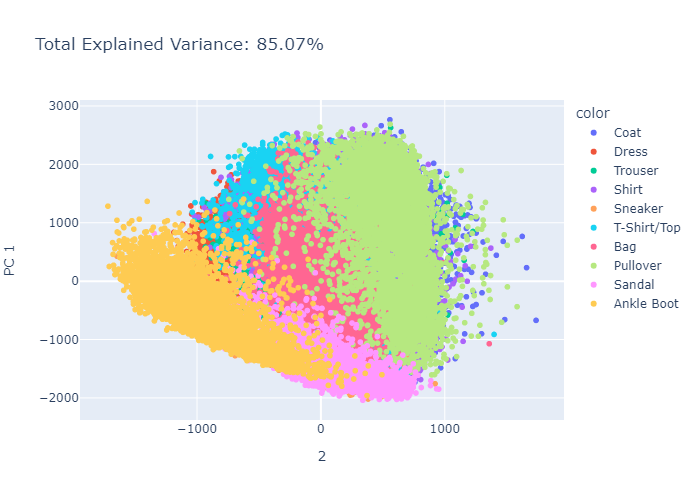

In [31]:
# 2D graph(PC3 and PC1)
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=2, y=0, color = label_numbers_to_clothes(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

In [32]:
# before jumping into models, we will perform a dimensional reduction with scaling using pipeline

In [33]:
preprocess = Pipeline([('scaler',StandardScaler(with_std=False)), ('pca',PCA(n_components=0.8))])
X_train_reduced = preprocess.fit_transform(X_train)
X_val_reduced = preprocess.transform(X_val)

In [34]:
# I will do that also on the full data for the cross validation.
# I will create a new PCA to prevent data leakage

In [35]:
features_test = df_test.drop(['label'], axis = 1)
targets_test = df_test['label']

full_data_preprocess = Pipeline([('scaler',StandardScaler(with_std=False)), ('pca',PCA(n_components=0.8))])
features_train_reduced = full_data_preprocess.fit_transform(features_train)
features_test_reduced = full_data_preprocess.transform(features_test)

In [36]:
# Models

In [37]:
# DummyClassifier
# A dummy classifier is a type of classifier which does not generate any insight about the data and classifies
# the given data using only simple rules.
# It is used only as a simple baseline for the other classifiers i.e. any other classifier
# is expected to perform better on the given dataset.

In [38]:
dm = DummyClassifier(strategy='most_frequent')
dm.fit(X_train_reduced,y_train)
y_pred = dm.predict(X_val_reduced)
dummy_acc = metrics.accuracy_score(y_val, y_pred)
print(dummy_acc)
print(classification_report(y_val,y_pred))

0.09533333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1150
           1       0.00      0.00      0.00      1191
           2       0.00      0.00      0.00      1249
           3       0.00      0.00      0.00      1217
           4       0.10      1.00      0.17      1144
           5       0.00      0.00      0.00      1215
           6       0.00      0.00      0.00      1224
           7       0.00      0.00      0.00      1144
           8       0.00      0.00      0.00      1217
           9       0.00      0.00      0.00      1249

    accuracy                           0.10     12000
   macro avg       0.01      0.10      0.02     12000
weighted avg       0.01      0.10      0.02     12000



C:\Users\matan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\matan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\matan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<AxesSubplot:>

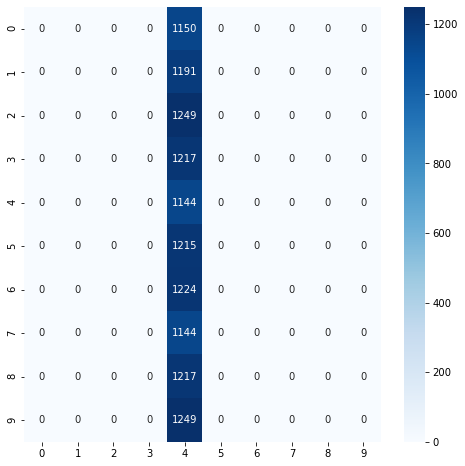

In [39]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [40]:
# Cross validation
dummy_acc = cross_val_score(DummyClassifier(strategy='most_frequent'), features_train_reduced, targets_train, cv = 10).mean()
print(dummy_acc)

0.1


In [41]:
# Not suprisingly, we got a lame accuracy result because the dummy classifier will classify always the most frequent label,
# which is the label 4.
# Note: originally, there is no most frequent (each label has 6000 samples in the train part).
# but from the random_state=7 we got that the most frequent label is 4

In [42]:
# KNN
# knn is one of the simplest and widely used classification algorithms,
# in which a new data point is classified based on similarity in the specific group of neighboring data points.

In [43]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_reduced,y_train)
y_pred = knn_clf.predict(X_val_reduced)
knn_acc = accuracy_score(y_val, y_pred)
print(knn_acc)
print (classification_report(y_val, y_pred))

0.8478333333333333
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1150
           1       0.99      0.96      0.97      1191
           2       0.74      0.78      0.76      1249
           3       0.87      0.88      0.88      1217
           4       0.74      0.78      0.76      1144
           5       0.96      0.88      0.92      1215
           6       0.67      0.54      0.60      1224
           7       0.87      0.93      0.90      1144
           8       0.96      0.97      0.97      1217
           9       0.91      0.94      0.92      1249

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000



<AxesSubplot:>

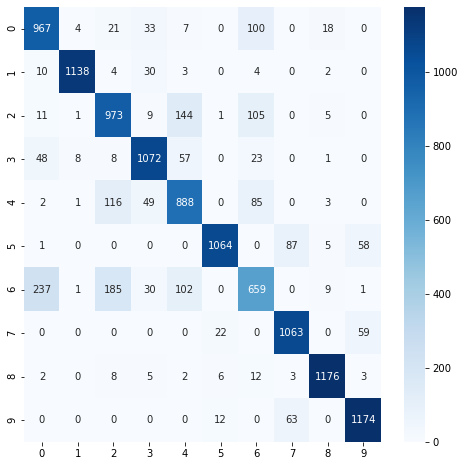

In [44]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [ ]:
# finding the best k using cross validation
index = 0
max_score = -sys.maxsize
for i in range(1,21):
    acc = cross_val_score(KNeighborsClassifier(n_neighbors = i), features_train_reduced, targets_train, cv = 10).mean()
    if (acc > max_score):
        index = i
        max_score = acc
knn_acc = max_score
print(index, ":  ", max_score)

In [ ]:
# Logistic regression
# Logistic Regression is a classification technique used in machine learning.
# It uses a logistic function to model the dependent variable.
# The dependent variable is dichotomous in nature, i.e. there could only be two possible classes
# (eg.: either the person is satisfied or not). 
# It chooses the final S line by computing all of the S lines likelyhood of observing
# the data and returns the S line that gives the maximum likelyhood.

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_val_reduced)
lr_acc = accuracy_score(y_val, y_pred)
print(lr_acc)
print (classification_report(y_val, y_pred)) 

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [ ]:
# Cross validation
lr_acc = cross_val_score(LogisticRegression(), features_train_reduced, targets_train, cv = 10).mean()
print(lr_acc)

In [ ]:
# Naive bayes
# based on applying Bayes' theorem with strong (naive) independence assumptions between the features.
bayes = GaussianNB()
bayes.fit(X_train_reduced, y_train)
y_pred = bayes.predict(X_val_reduced)
bayes_acc = accuracy_score(y_val, y_pred)
print(bayes_acc)
print (classification_report(y_val, y_pred))

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [ ]:
# Cross validation
bayes_acc = cross_val_score(GaussianNB(), features_train_reduced, targets_train, cv = 10).mean()
print(bayes_acc)

In [ ]:
# More advanced models

In [ ]:
# Random Forest
# Random forest is comprised of multiple decision trees that work together as an ensemble to produce one prediction.
#A decision tree is a logical construct that resembles a flowchart and illustrates a series of if-else statements
# An important purpose of using random forest is to compensate for the limitations of decision tree algorithms by mapping multiple trees and using the forest's average output.

In [ ]:
rf = RandomForestClassifier(random_state=7)
rf.fit(X_train_reduced, y_train)
y_pred = rf.predict(X_val_reduced)
rf_acc = accuracy_score(y_val, y_pred)
rf_acc
print (classification_report(y_val, y_pred))

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [ ]:
# Cross validation
rf_acc = cross_val_score(RandomForestClassifier(random_state=7), features_train_reduced, targets_train, cv = 10).mean()
print(rf_acc)

In [ ]:
# CatBoost
# CatBoost is based on gradient boosted decision trees.
# During training, a set of decision trees is built consecutively.
# Each successive tree is built with reduced loss compared to the previous trees.
# The number of trees is controlled by the starting parameters.

In [ ]:
cat = CatBoostClassifier(logging_level='Silent')
cat.fit(X_train_reduced, y_train)
y_pred = cat.predict(X_val_reduced)
y_pred_cat = y_pred
cat_acc = accuracy_score(y_val, y_pred)
print(cat_acc)
print (classification_report(y_val, y_pred))

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [ ]:
# Cross validation
cat_acc = cross_val_score(CatBoostClassifier(logging_level='Silent'), features_train_reduced, targets_train, cv = 10).mean()
print(cat_acc)

In [ ]:
# AdaBoost
# AdaBoost algorithm, short for Adaptive Boosting, is a Boosting technique used as an Ensemble Method in Machine Learning.
# It is called Adaptive Boosting as the weights are re-assigned to each instance,
# with higher weights assigned to incorrectly classified instances.

In [ ]:
rfc = RandomForestClassifier(random_state=7)
ada = AdaBoostClassifier(n_estimators=100,learning_rate= 0.1, base_estimator=rfc)
ada.fit(X_train_reduced, y_train)
y_pred = ada.predict(X_val_reduced)
ada_acc = accuracy_score(y_val, y_pred)
print(ada_acc)
print (classification_report(y_val, y_pred))

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [ ]:
# Cross validation
ada_acc = cross_val_score(AdaBoostClassifier(n_estimators=100,learning_rate= 0.1, base_estimator=rfc), features_train_reduced, targets_train, cv = 10).mean()
print(ada_acc)

In [ ]:
# XGBoost
# XGBoost, which stands for Extreme Gradient Boosting, is a scalable,
# distributed gradient-boosted decision tree (GBDT) machine learning library.
# It provides parallel tree boosting and is the leading machine learning library for regression,
# classification, and ranking problems.

In [ ]:
xgb = XGBClassifier(use_label_encoder =False)
xgb.fit(X_train_reduced, y_train)
y_pred = xgb.predict(X_val_reduced)
xgb_acc = accuracy_score(y_val, y_pred)
print(xgb_acc)
print (classification_report(y_val, y_pred))

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [ ]:
# Cross validation
xgb_acc = cross_val_score(XGBClassifier(use_label_encoder =False), features_train_reduced, targets_train, cv = 10).mean()
print(xgb_acc)

In [ ]:
# Voting
clf1 = xgb
clf2 = knn_clf
clf3 = rf
clf4 = cat

In [ ]:
# hard voting
# In hard voting (also known as majority voting), every individual classifier votes for a class, and the majority wins.
# In statistical terms, the predicted target label of the ensemble is the mode of the distribution of individually predicted
# labels.

In [ ]:
hv = VotingClassifier(estimators=[('xgb', clf1), ('knn', clf2), ('rf', clf3)], voting='hard')
hv.fit(X_train_reduced, y_train)
y_pred = hv.predict(X_val_reduced)
hv_acc = accuracy_score(y_val, y_pred)
print(hv_acc)
print(classification_report(y_val, y_pred))

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [ ]:
# Cross validation
hv_acc = cross_val_score(VotingClassifier(estimators=[('xgb', clf1), ('knn', clf2), ('rf', clf3)], voting='hard'), features_train_reduced, targets_train, cv = 10).mean()
print(hv_acc)

In [ ]:
# soft voting
# In soft voting, every individual classifier provides a probability value that a specific data point belongs
# to a particular target class. The predictions are weighted by the classifier's importance and summed up.
# Then the target label with the greatest sum of weighted probabilities wins the vote.

In [ ]:
sv = VotingClassifier(estimators=[('xgb', clf1), ('cat', clf4), ('rf', clf3)], voting='soft', weights=[1,3,1])
sv.fit(X_train_reduced, y_train)
y_pred = sv.predict(X_val_reduced)
sv_acc = accuracy_score(y_val, y_pred)
sv_acc
print(classification_report(y_val, y_pred))   

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [ ]:
# Cross validation
sv_acc = cross_val_score(VotingClassifier(estimators=[('xgb', clf1), ('cat', clf4), ('rf', clf3)], voting='soft', weights=[1,3,1]), features_train_reduced, targets_train, cv = 10).mean()
print(sv_acc)

In [ ]:
# Stacking
# The simplest form of stacking can be described as an ensemble learning technique where the predictions
# of multiple classifiers (referred as level-one classifiers) are used as new features to train a meta-classifier.
# The meta-classifier can be any classifier of your choice.

In [ ]:
stc = StackingClassifier(estimators=[('knn',knn), ('rf',rf), ('xgb',xgb),], final_estimator= xgb)
stc.fit(X_train_reduced,y_train)
stc.score(X_val_reduced, y_val)

In [ ]:
# Cross validation
stc_acc = cross_val_score(StackingClassifier(estimators=[('knn' , knn), ('rf', rf), ('xgb' , xgb)], final_estimator=xgb), features_train_reduced, targets_train, cv = 10).mean()
print(stc_acc)

In [ ]:
# HyperParameters Tuning
# For improvment, we will use GridSearchCV on our best model.

# The GridSearchCV chooses parameters between all of the possible combinations we have given in 'param_grid'.

# Evantually, we can see which parameters combination gives us the best score.

In [ ]:
# testing the model itself

In [ ]:
# y_pred = search.predict(X_test_reduced)
# final_acc = accuracy_score(y_val, y_pred)
# print(final_acc)
# print(classification_report(y_val, y_pred))

In [ ]:
# Conclusion